# Implemented U-Net for Segmentation of Nuclei

In [ ]:
%reset

In [1]:
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import rotate
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
from skimage.morphology import label, binary_dilation
from skimage import filters
from skimage.transform import resize
from skimage.segmentation import relabel_sequential
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa
# CONSTANTS
Train_Path = '.\\DataSet\\stage1_train\\*'
Test_Path = '.\\DataSet\\stage1_test\\*'

In [3]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dropout, Input, MaxPooling2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as CallBacks
from keras import backend as K
import tensorflow as tf

In [4]:
def Gen_Buckets(Images, Masks, return_sizes = False): # BUCKETING IMAGES WITH SAME RESOLUTION TOGETHER
    Shape = [[image.shape[0], image.shape[1]] for image in Images]
    Unique_Shapes = np.unique(Shape, axis=0)

    Image_Buckets = []
    Mask_Buckets = []
    for shape in Unique_Shapes:
        image_bucket = []
        mask_bucket = []
        for image, mask in zip(Images, Masks):
            if (image.shape[0] ==  shape[0]) &  (image.shape[1] == shape[1]):
                image_bucket.append(image)
                mask_bucket.append(mask)
        Image_Buckets.append(np.array(image_bucket))
        Mask_Buckets.append(np.array(mask_bucket))
    if return_sizes:
        return Image_Buckets, Mask_Buckets, Unique_Shapes
    else:
        return Image_Buckets, Mask_Buckets

def Normalize_Images(Images, divide_by = 255): # Normalizing Images B/W 0 and 1.
    if divide_by == 'max':
        return [ image/image.max() for image in Images]
    else:
        return [ image/divide_by for image in Images]
    
# Augmentated Image Generator
def Augment_Images(Images, Masks, fliplr = True, flipud = True, Rot = None, 
                   Rot_Mode = 'edge', Rot90 = True, return_numpy=True):
    # Rot  = Does small angular rotations but keeps the dimensions same.
    # Rot90= Rotates image by multiples of 90 degree and changes the dimensions
    Aug_Images = []
    Aug_Mask =   []
    for image, mask in zip(Images, Masks):
        aug_img = image
        aug_mask = mask
        if fliplr:
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.fliplr(aug_img)
                aug_mask = np.fliplr(aug_mask)
        if flipud:
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.flipud(aug_img)
                aug_mask = np.flipud(aug_mask)
        if Rot90:
            if np.random.uniform(low=0, high=1)>0.5:
                k = np.random.randint(low=0, high=4)
                aug_img = np.rot90(aug_img, k = k, axes=(0,1))
                aug_mask = np.rot90(aug_mask, k = k, axes=(0,1))
        if Rot != None:
            if np.random.uniform(low=0, high=1) > 0.5:
                angle = np.random.uniform(low=0, high = Rot)
                aug_img = rotate(aug_img, angle, mode = Rot_Mode)
                aug_mask = rotate(aug_mask, angle, mode = Rot_Mode)
        Aug_Images.append(aug_img)
        Aug_Mask.append(aug_mask)
        
    if return_numpy:
        return np.array(Aug_Images), np.array(Aug_Mask)
    return Aug_Images, Aug_Mask

# Rescaling the Images
def Rescale_Images(Images, Masks, size=(256,256), order=3, mode='constant'):
    Images_Resized = []; Masks_Resized = [];
    if Masks == None:
        for image in Images:
            img = resize(image, size, order, mode, preserve_range = True )
            Images_Resized.append(img)
        return np.array(Images_Resized)
    else:
        for image, mask in zip(Images, Masks):
            img = resize(image, size, order, mode, preserve_range = True )
            msk = resize(mask,  size, order, mode, preserve_range = True )

            Images_Resized.append(img)
            Masks_Resized.append(msk)
        
        return np.array(Images_Resized), np.array(Masks_Resized)

def Load_Training_Data(Train_Path, return_mask_report=True):
    Images = []
    Masks = []     # Stores masks by adding them
    Masks_Obj = [] # Stores masks as is, donot add
    Number_Of_Masks = []
    for path in tqdm(glob(Train_Path)):
        image_path = glob(path + '\\images\\*.png')
        assert len(image_path) == 1
        Images.append(imread(image_path[0])[:,:,:3])    
        masks = glob(path + '\\masks\\*.png')
        mask = []
        for m in masks:
            mask.append(imread(m))
        Number_Of_Masks.append(len(mask))
        Masks_Obj.append(np.array(mask))
        mask = np.sum(mask, axis=0)
        mask = np.expand_dims(mask, axis=-1)
        Masks.append(mask)
    if return_mask_report:
        return Images, Masks,Masks_Obj, np.array(Number_Of_Masks)
    else:
        return Images, Masks,Masks_Obj
    
def Load_Test_Data(Test_Path, return_testid=True):
    Test_Images = []
    Test_Id = []
    for path in tqdm(glob(Test_Path)):
        image_path = glob(path + '\\images\\*.png')
        test_id = glob(path + '\\images\\*.png')[0].split('\\')[-1][:-4]
        assert len(image_path) == 1
        Test_Images.append(imread(image_path[0])[:,:,:3])    
        Test_Id.append(test_id)
    if return_testid:
        return Test_Images, Test_Id
    else:
        return Test_Images

In [5]:
# LOADING TRAINING DATA
Images, Masks, Masks_Obj, Number_Of_Masks = Load_Training_Data(Train_Path, return_mask_report=True )

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:39<00:00,  6.71it/s]


# Removing Outliers and Pre-Processing Data for Training

We check for any mask that does not have labels for objects in the microscopic images. We see that image at index = 332 does not masks for all the objects in the image. We remove this image from the dataset.

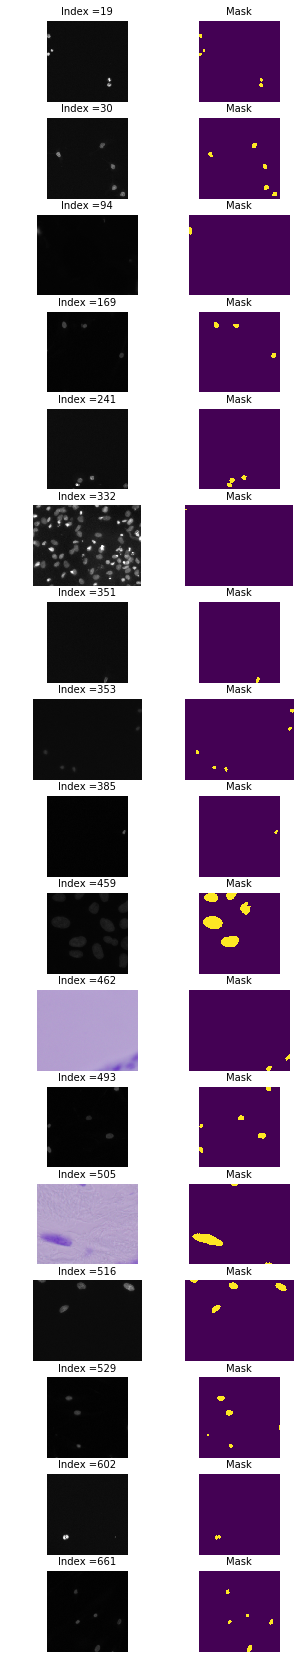

In [7]:
# ANALYSING NUMBER OF MASK FOR OUTLIERS IN DATA
Threshold_On_Masks = 6
idx = np.argwhere(Number_Of_Masks < Threshold_On_Masks).reshape(-1)
Images_Outliers = []
Masks_Outliers = []
for i in idx:
    Images_Outliers.append(Images[i])
    Masks_Outliers.append(Masks[i])
f, ax = plt.subplots(idx.shape[0], 2, figsize=(5,30))
for i in range(idx.shape[0]):
    ax[i,0].imshow(Images_Outliers[i])
    ax[i,0].set_title(str('Index ='+ str(idx[i])), size=10)
    ax[i,1].imshow(Masks_Outliers[i][:,:,0])
    ax[i,1].set_title('Mask', size=10)
    ax[i,0].axis('Off')
    ax[i,1].axis('Off')
plt.show()

In [8]:
# Deleting Outlier from Images
del_idx = [332, 36] # Also 36 because no such image is present in Test Set.
for idx in del_idx:
    del Images[idx]
    del Masks[idx]
    del Masks_Obj[idx]

In [9]:
# UNIQUE SIZES IN TRAINING DATASET
_,_, sizes = Gen_Buckets(Images, Masks, return_sizes=True)
print(sizes)

[[ 256  256]
 [ 256  320]
 [ 512  640]
 [1024 1024]
 [ 260  347]
 [ 520  696]
 [1040 1388]
 [ 603 1272]
 [ 360  360]]


In [10]:
# Normalizing Images
Images = Normalize_Images(Images, divide_by = 255)
Masks = Normalize_Images(Masks, divide_by = 255)

In [11]:
# Rescaling Training Data to 256x256
Images, Masks = Rescale_Images(Images, Masks, size=(256,256), order=3, mode='constant')

## Splitting Training and Validation Data 

In [12]:
X_Train, X_Val, Mask_Train   , Mask_Val =     train_test_split( Images, Masks, test_size=0.3, random_state=42)
_      ,   _ , Mask_Obj_Train, Mask_Obj_Val = train_test_split( Images, Masks_Obj, test_size=0.3, random_state=42)

In [13]:
del Images, Masks

In [14]:
for i in tqdm(range(2)):
    image, mask = Augment_Images(X_Train, Mask_Train, 
                                 fliplr = True, flipud = True, 
                                 Rot = 3, Rot_Mode = 'edge', 
                                 Rot90 = True)
    X_Train = np.concatenate([X_Train, image], axis=0)
    Mask_Train = np.concatenate([Mask_Train, mask], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.40s/it]


In [15]:
# X_Train_Buckets, Mask_Train_Buckets = Gen_Buckets(X_Train, Mask_Train)
# X_Val_Buckets,  Mask_Val_Buckets = Gen_Buckets(X_Val, Mask_Val) 

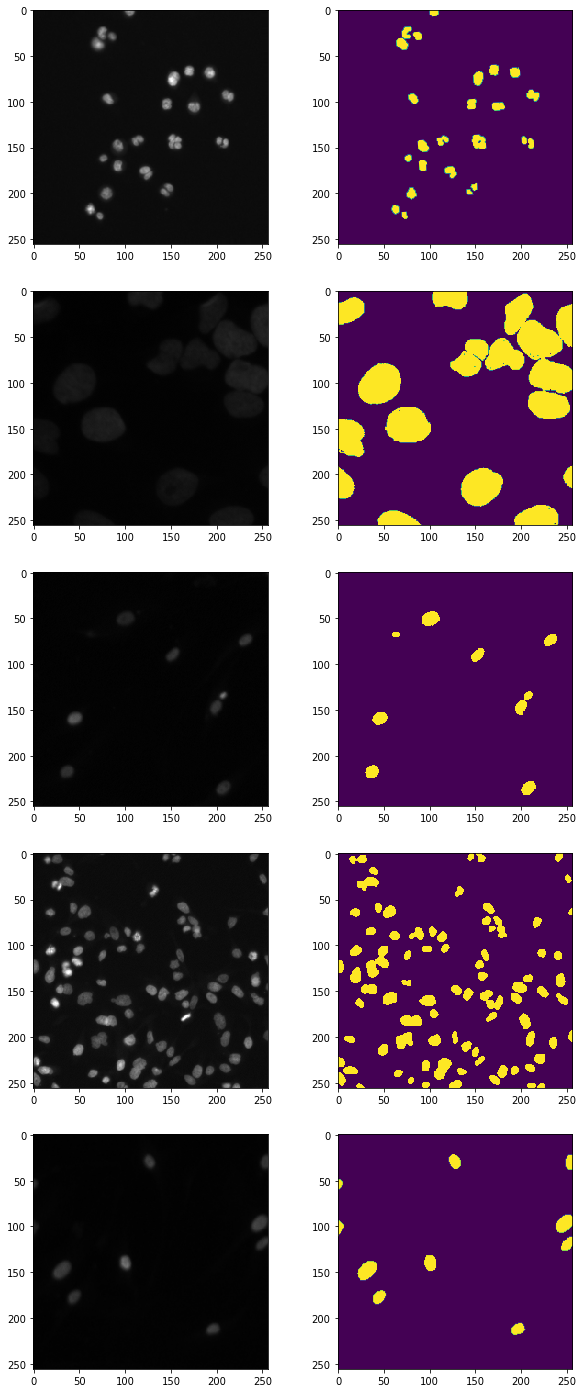

In [17]:
# Visualizing Results
N = 5
idx = np.random.randint(len(X_Train), size=(N,))

f, ax = plt.subplots(N,2,figsize=(10,5*N))
for i in range(N):
    ax[i,0].imshow(X_Train[int(idx[i])])
    ax[i,1].imshow(Mask_Train[int(idx[i])][:,:,0])
plt.show()

In [18]:
alpha = 0.1
drop_rate = [0.1,0.2,0.25,0.3,0.5]
drop_rate = [0,  0,  0,   0,  0]

# KERAS MODEL DEF.
Unet_Input = Input(shape=(256, 256,3))

# Segment No. 1
conv1_1 = Conv2D(32, kernel_size=(3,3), strides = (1,1), padding = 'same')(Unet_Input)
relu1_1 = LeakyReLU(alpha = alpha)(conv1_1)

conv1_2 = Conv2D(32, kernel_size=(3,3), strides = (1,1), padding = 'same')(relu1_1)
relu1_2 = LeakyReLU(alpha = alpha)(conv1_2)

bn1   =  BatchNormalization()(relu1_2)
maxpool1 = MaxPooling2D(pool_size = (2,2), strides = (2,2))(bn1)

# Segment No. 2 
conv2_1 = Conv2D(64, kernel_size=(3,3), strides = (1,1), padding = 'same')(maxpool1)
relu2_1 = LeakyReLU(alpha = alpha)(conv2_1)

conv2_2 = Conv2D(64, kernel_size=(3,3), strides = (1,1), padding = 'same')(relu2_1)
relu2_2 = LeakyReLU(alpha = alpha)(conv2_2)

bn2   =  BatchNormalization()(relu2_2)
maxpool2 = MaxPooling2D(pool_size = (2,2), strides = (2,2))(bn2)

# Segment No. 3 
conv3_1 = Conv2D(128, kernel_size=(3,3), strides = (1,1), padding = 'same')(maxpool2)
relu3_1 = LeakyReLU(alpha = alpha)(conv3_1)

conv3_2 = Conv2D(128, kernel_size=(3,3), strides = (1,1), padding = 'same')(relu3_1)
relu3_2 = LeakyReLU(alpha = alpha)(conv3_2)

bn3   =  BatchNormalization()(relu3_2)
maxpool3 = MaxPooling2D(pool_size = (2,2), strides = (2,2))(bn3)

# Segment No. 4 
conv4_1 = Conv2D(256, kernel_size=(3,3), strides = (1,1), padding = 'same')(maxpool3)
relu4_1 = LeakyReLU(alpha = alpha)(conv4_1)

conv4_2 = Conv2D(256, kernel_size=(3,3), strides = (1,1), padding = 'same')(relu4_1)
relu4_2 = LeakyReLU(alpha = alpha)(conv4_2)

bn4   =  BatchNormalization()(relu4_2)
maxpool4 = MaxPooling2D(pool_size = (2,2), strides = (2,2))(bn4)

#------------------------------------------

# Segment No. 5
conv5_1 = Conv2DTranspose(256, kernel_size=(3,3), strides = (2,2), padding = 'same')(maxpool4)
relu5_1 = LeakyReLU(alpha = alpha)(conv5_1)

conc5   = Concatenate(axis=3)([relu5_1, relu4_2])

conv5_2 = Conv2D(256, kernel_size=(3,3), strides = (1,1), padding = 'same')(conc5)
relu5_2 = LeakyReLU(alpha = alpha)(conv5_2)

bn5   = BatchNormalization()(relu5_2)

# Segment No. 6
conv6_1 = Conv2DTranspose(128, kernel_size=(3,3), strides = (2,2), padding = 'same')(bn5)
relu6_1 = LeakyReLU(alpha = alpha)(conv6_1)

conc6   = Concatenate(axis=3)([relu6_1, relu3_2])

conv6_2 = Conv2D(128, kernel_size=(3,3), strides = (1,1), padding = 'same')(conc6)
relu6_2 = LeakyReLU(alpha = alpha)(conv6_2)

bn6   = BatchNormalization()(relu6_2)

# Segment No. 7
conv7_1 = Conv2DTranspose(64, kernel_size=(3,3), strides = (2,2), padding = 'same')(bn6)
relu7_1 = LeakyReLU(alpha = alpha)(conv7_1)

conc7   = Concatenate(axis=3)([relu7_1, relu2_2])

conv7_2 = Conv2D(64, kernel_size=(3,3), strides = (1,1), padding = 'same')(conc7)
relu7_2 = LeakyReLU(alpha = alpha)(conv7_2)

bn7   = BatchNormalization()(relu7_2)

# Segment No. 8
conv8_1 = Conv2DTranspose(32, kernel_size=(3,3), strides = (2,2), padding = 'same')(bn7)
relu8_1 = LeakyReLU(alpha = alpha)(conv8_1)

conc8   = Concatenate(axis=3)([relu8_1, relu1_2])

conv8_2 = Conv2D(32, kernel_size=(3,3), strides = (1,1), padding = 'same')(conc8)
relu8_2 = LeakyReLU(alpha = alpha)(conv8_2)

Unet_Output = Conv2D(1, kernel_size=(1,1), strides = (1,1), padding='same', activation='sigmoid')(relu8_2)

Unet = Model(Unet_Input, Unet_Output)

In [19]:
# Unet.summary()

In [20]:

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [21]:
LearningRate = 0.00001#0.0001
BatchSize =  16 

sgd = SGD(lr = LearningRate)
adam = Adam(lr = LearningRate)
Unet.compile(optimizer = sgd, loss = dice_coef_loss, metrics=['accuracy', mean_iou] )
# Unet.load_weights('./Unet/Unet - Weights.h5')

In [224]:
# Unet.save_weights('./Unet/Unet - Weights.h5')

In [22]:
checkpoints = CallBacks.ModelCheckpoint('./Unet/checkpoints/', monitor= 'val_mean_iou', verbose=0, 
                save_best_only=True, save_weights_only=False, mode='auto', period=1)

tensorboard = CallBacks.TensorBoard(log_dir='./Unet/logs2', histogram_freq=0, batch_size=BatchSize, 
                      write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, 
                      embeddings_layer_names=None, embeddings_metadata=None)

red_lr = CallBacks.ReduceLROnPlateau(monitor='val_mean_iou', factor=0.25, patience=20, verbose=1, mode='auto', 
                  epsilon=0.01, cooldown=0, min_lr=0.000001)

callbacks = [red_lr]

In [ ]:
hist = Unet.fit(X_Train, Mask_Train, validation_data=(X_Val, Mask_Val), 
               batch_size = BatchSize, epochs = 500 ,shuffle=True, verbose=2, callbacks = callbacks )        

# GENERATING TEST PREDICTIONS

In [28]:
# LOading TEST DATA
Test_Images_Orig, Test_Id = Load_Test_Data(Test_Path,return_testid = True )
Orig_Shape = [ image.shape[:-1] for image in Test_Images_Orig]
Test_Images = Normalize_Images(Test_Images_Orig, divide_by = 255)
Test_Images = Rescale_Images(Test_Images, Masks=None, size=(256,256), order=3, mode='constant')

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 183.60it/s]


In [29]:
Pred_Masks = Unet.predict(Test_Images, batch_size = BatchSize)[:,:,:,0]
Pred_Masks_upsampled = []
for i in range(Pred_Masks.shape[0]):
    mask_upsampled = resize(Pred_Masks[i], Orig_Shape[i], order = 3, mode='constant', preserve_range = True )
    Pred_Masks_upsampled.append(mask_upsampled)

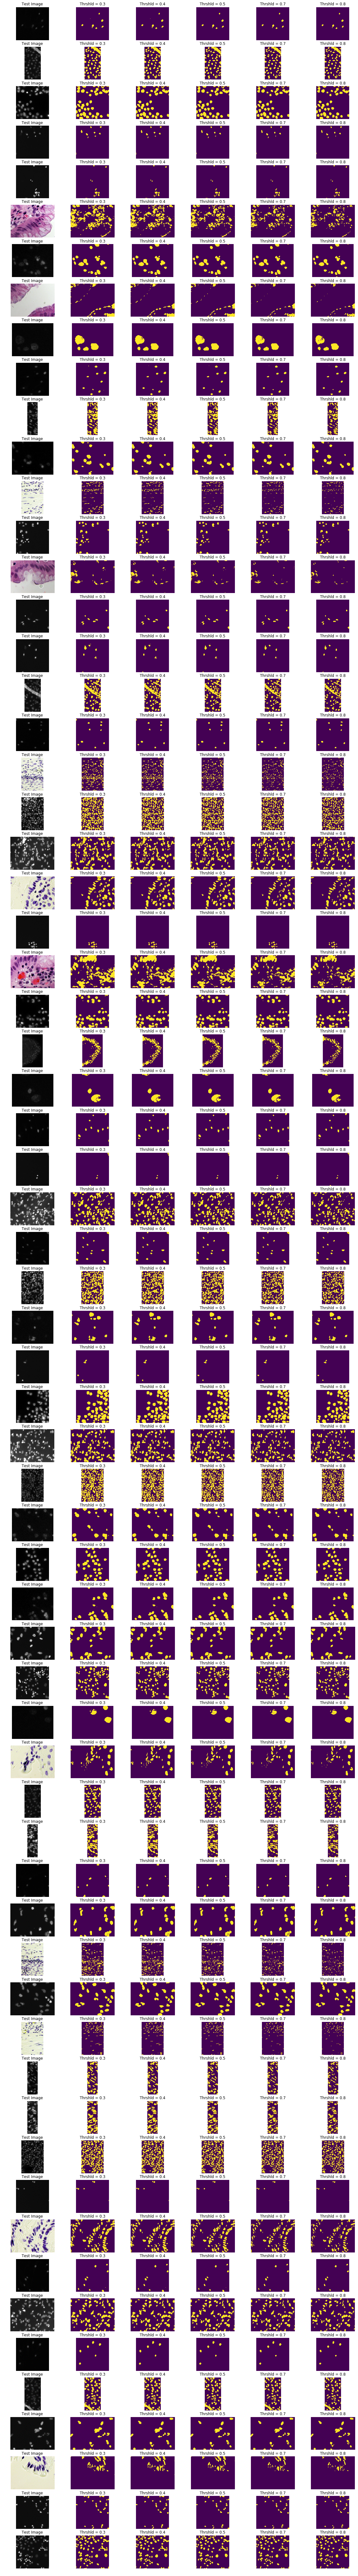

In [30]:
f, ax = plt.subplots(Test_Images.shape[0], 6, figsize=(20,150))
i = 0
for image, mask in zip(Test_Images_Orig, Pred_Masks_upsampled):
    ax[i,0].imshow(image[:,:,:3])
    ax[i,0].axis('Off')
    m = np.where(mask>0.3, 1, 0)
    ax2 = ax[i,1].imshow(m)
    ax[i,1].axis('Off')
    m = np.where(mask>0.4, 1, 0)
    ax2 = ax[i,2].imshow(m)
    ax[i,2].axis('Off')
    m = np.where(mask>0.5, 1, 0)
    ax2 = ax[i,3].imshow(m)
    ax[i,3].axis('Off')
    m = np.where(mask>0.7, 1, 0)
    ax2 = ax[i,4].imshow(m)
    ax[i,4].axis('Off')
    m = np.where(mask>0.8, 1, 0)
    ax2 = ax[i,5].imshow(m)
    ax[i,5].axis('Off')
    
    ax[i,0].set_title('Test Image')
    ax[i,1].set_title('Thrshld = 0.3')
    ax[i,2].set_title('Thrshld = 0.4')
    ax[i,3].set_title('Thrshld = 0.5')
    ax[i,4].set_title('Thrshld = 0.7')
    ax[i,5].set_title('Thrshld = 0.8')

    i = i+1
plt.show()

In [31]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.7):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [32]:
new_test_ids = []
rles = []
for n, id_ in enumerate(Test_Id):
    rle = list(prob_to_rles(Pred_Masks_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [33]:
submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
submission_df.to_csv('U-Net.csv', index=False)